# Assignment Sheet 2

Bruce Schultz  
bschultz@uni-bonn.de

Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com

## Exercise 1

In [1]:
# Requiered libraries
import os
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import palettable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product

In [2]:
def interpolate_by_mean(column):
    """
    Interpolates missing values by the mean
    :param column: A pandas dataframe
    :return: A pandas dataframe containing the column names which have null values
    """
    return column.fillna(int(round(column.mean()))) if any(column.isnull()) else column

In [3]:
def get_f_score (attribute, groups, exclude =[]):
    """
    Calculates the F score of an attribute between to groups (for now)
    :param data: Pandas dataframe
    :param column: Pandas Series
    :param groupby: Column with the categories
    :param exclude: List of columns to be excluded from the calculation
    """
    if attribute.name in exclude:
        return None
    else:        
        # Get means for groups
        grand_mean = attribute.mean()
        g1_mean = groups[0][attribute.name].mean() # Group 1
        g2_mean = groups[1][attribute.name].mean() # Group 2
        
        g1_diff = [(i-g1_mean)**2 for i in groups[0][attribute.name]] # Group 1
        g2_diff = [(i-g2_mean)**2 for i in groups[1][attribute.name]] # Group 2
        
        numerator = (g1_mean - grand_mean)**2 + (g2_mean - grand_mean)**2
        denom = (1/(len(groups[0][attribute.name])-1))*sum(g1_diff) + \
                (1/(len(groups[1][attribute.name])-1))*sum(g2_diff)
        
        return numerator/denom

In [4]:
def cluster_center(points):
    '''
    Computes the center point from a list of points
    :param points: Can be a list of lists of tuples containing points
    :return: A list with center point for each set of points provided, in numpy array format
    '''
    cluster_centers = [np.array([0, 0]) for dataset in points]
    for i in range(len(points)):
        for datapoint in points[i]:
            cluster_centers[i] = np.add(np.array(datapoint), cluster_centers[i])
        cluster_centers[i] = cluster_centers[i]/len(points[i])
    return cluster_centers

In [5]:
def DSC(point_list):
    '''
    Computers Distance consistency for a set (or sets) of points
    :param point_list: A list of points in tuple format
    :return: Numerical computation of the Distance consistency for all points provided
    '''
    # First computer center points
    centers = cluster_center(point_list)
    #Create empty lists to store distances of the difference between each point and each centroid
    same_cluster_distances = []
    diff_cluster_distances = []
    for i in range(len(point_list)):
        for datapoint in point_list[i]:
            for j in range(len(point_list)):
                # Alternate between same centroid and diff centroids, store in list
                if i == j:
                    same_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[i]))
                else:
                    diff_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[j]))
    # Create counter to keep track points closer to their own centroid
    closer_points = 0
    for k in range(len(same_cluster_distances)):
        if same_cluster_distances[k] < diff_cluster_distances[k]:
            closer_points += 1
    return (100*closer_points/len(same_cluster_distances))

In [6]:
def get_DSC(data, columns):
    n = len(columns)  # Number of attributes to be used
    # zip together the column names and the position on the matrix
    # this will avoid using nested loops
    col = product(columns, repeat=2)
    idx = product(range(n), repeat=2)
    
    # Collect DSC values
    DSC_values = []
    
    # iterate over columns(c1,c2) combinations and plot
    for attr, idx in zip(col, idx):
        # Unpacking values
        i, j = idx
        attrx, attry = attr
        
        if i != j:
            # Setup to calculate DSC
            benign_scatter = list(zip(benign_imputed[attrx], benign_imputed[attry]))
            malig_scatter = list(zip(malig_imputed[attrx], malig_imputed[attry]))
            all_points = [benign_scatter, malig_scatter]
            DSC_values.append(('{} and {}'.format(attrx, attry), DSC(all_points)))
    return DSC_values

In [7]:
def plot_matrix_scatterplot(data, columns, diag_kind="hist",**plot_kwargs):
    '''
    Generates scatterplots of the attribute combinations that had the highest num_attr F scores \
    in the non-diagonal spots and histograms of the benign and malignant frequencies for each attr. \
    Also calculates distance consistency for every combination of attributes used and prints out results
    :param filepath: Filepath destination to the data
    :param num_attr: Number of attributes to be used in graphs
    :return:
    '''
    # Subset data based on most significant attributes
    # Generate figure for plots to be plotted in
    n = len(columns)  # Number of attributes to be used
    fig, subs = plt.subplots(n, n, figsize=(15, 15))

    # zip together the column names and the position on the matrix
    # this will avoid using nested loops
    col = product(columns, repeat=2)
    idx = product(range(n), repeat=2)

    # Create colors list
    colors = ["blue" if row is 2 else "red" for row in list(data['class'])]

    # iterate over columns(c1,c2) combinations and plot
    for attr, idx in zip(col, idx):
        # Unpacking values
        i, j = idx
        attrx, attry = attr

        if i == j:
            # Pandas implementation, but tecnically this is also matplotlib
            # I prefer using this one since it allows the function to
            # be generalizable 
            data[attrx][data["class"] == 2].plot(ax = subs[i,j], kind=diag_kind,
                                                 color="blue",label="benign",**plot_kwargs)
            data[attrx][data["class"] == 4].plot(ax = subs[i,j], kind=diag_kind,
                                                 color="red",label="malignant",**plot_kwargs)
            
            # Matplotlib implementation
            #subs[i, j].hist(data[attrx][data["class"] == 2], color="blue",
            #t                alpha=0.5, histtype='bar', label="benign", edgecolor='black')
            #subs[i, j].hist(data[attrx][data["class"] == 4], color="red",
            #                alpha=0.5, histtype='bar', label="malignant", edgecolor='black')
        else:
            # Generate sizes by counting number of times a point occurs
            datapoints = list(zip(data[attrx], data[attry]))
            sizes = [datapoints.count(point)*2 for point in datapoints]
            
            # Create scatter plot at position i,j using created sizes/colors, alpha used for overlapping points
            subs[i, j].scatter(data[attrx], data[attry], alpha=0.25, c=colors, s=sizes)

        # Print titles for columns
        if i == 0:
            subs[i, j].set_title(attry)

        # Print titles for rows
        if j == 0:
            subs[i, j].set_ylabel(attrx)

    # Figure attributes
    subs[0, 0].legend(bbox_to_anchor=(-0.2, 1.0))
    fig.suptitle('Malignant and Benign Tumor Values', x=0.5, y=0.91)

    #fig.savefig('Scatter Plot.png')
    #fig.show()

The highest distance consistancy is 93.41917024320458 and found between thickness and blaChroma


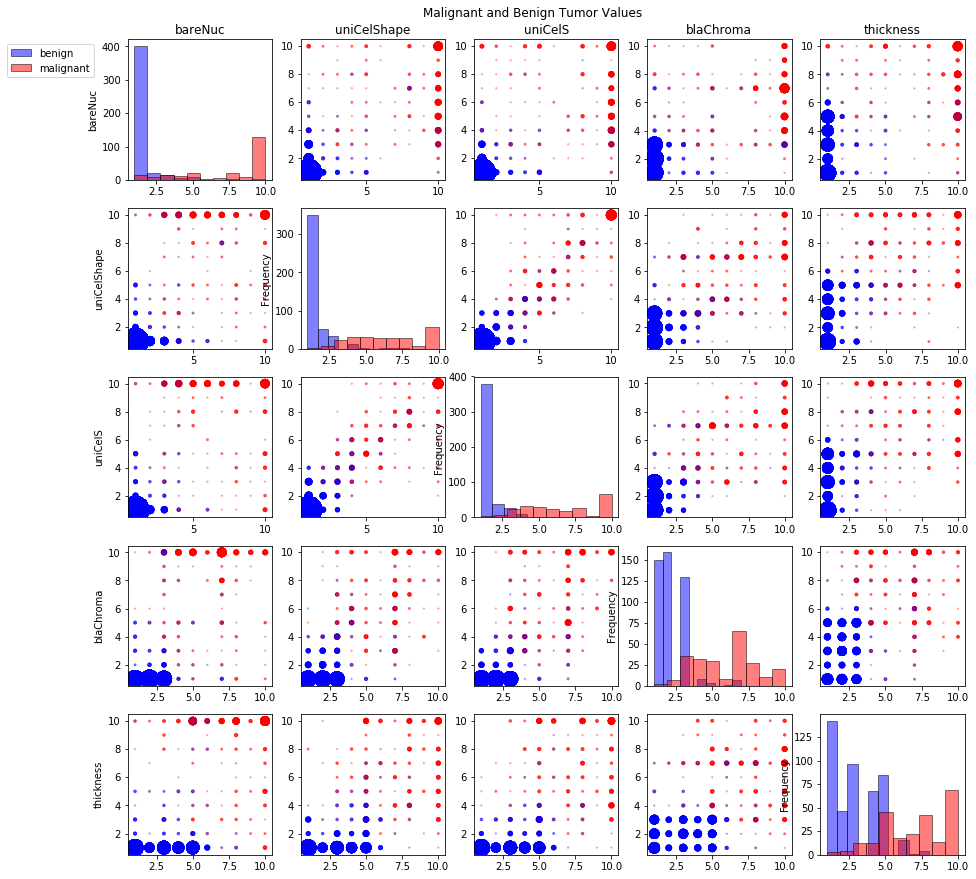

In [8]:
# Read file to pandasDF
filepath = "breast-cancer-wisconsin.xlsx"
data_df = pd.read_excel(os.path.abspath(filepath), index_col="code")

# For the moment let's just interpolate missing data by class
# Interpolating missing values to each column
benign_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
malig_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
data_imputed = pd.concat([malig_imputed, benign_imputed])

# Calculate F-Score for the imputed data
fscores = data_imputed.apply(get_f_score, axis=0, exclude=["class"],
                             groups=[benign_imputed, malig_imputed])

# Sort fscores
#fscores = fscores.sort_values(ascending=False)
columns = fscores.nlargest(n=5)

# Determine max DSC value and return highest one
DSC_values= get_DSC(data_imputed, columns.index)
print("The highest distance consistancy is {} and found between {}".format(DSC_values[-1][1], DSC_values[-1][0]))

# Plot scatterplot matrix
plot_matrix_scatterplot(data_imputed, columns.index, alpha=0.5,histtype="bar",edgecolor="black")

# Exercise 2 (Principal Component Analysis, 25 Points)

In [9]:
# Here come the functions for Exercise 2

def runPCA(data, exclude=[]):
    '''
    Perform PCA on a dataset
    :param data: Pandas dataset
    :param exclude: columns to exclude during PCA analysis
    :return:
    '''

    # Drop excluded columns (non-PCA features)
    data = data.drop(columns=exclude)
    
    # Initialize PCA class with default values
    pca = PCA()

    # Get scores of PCA (Fit PCA)
    scores = pca.fit_transform(data)

    # Get loadings
    loadings = pca.components_

    # Get aditional information out of PCA (summary)
    sd = scores.std(axis=0)
    var = pca.explained_variance_ratio_
    cumVar = var.cumsum()

    # Create summay file
    summary = np.array([sd, var, cumVar]).T

    # Create headers
    header = ["PC{0}".format(x + 1) for x in range(summary.shape[0])]

    # Convert loadings, scores and summaries to Pandas DataFrame rename index
    # TODO use standardized data, fix below commands to work with lists not np arrays \
    # or convert standardized data into numpy array
    df_scores = pd.DataFrame(data=scores, index=data.index, columns=header)
    df_loadings = pd.DataFrame(data=loadings, index=header, columns=data.columns)
    df_summary = pd.DataFrame(data=summary, index=header, columns=["standard_deviation",
                                                                   "proportion_of_variance_explained",
                                                                   "cumulative_proportion_of_variance_explained"])

    return df_scores, df_loadings, df_summary

def get_colors_cmappalette(elements):
    palette = palettable.colorbrewer.sequential.Blues_9
    
    # Get a color map
    mpl_colors = palette.mpl_colors
    
    # Subsetting colors as python default
    mpl_colors = mpl_colors[int(3):int(palette.number)]

    # Re calculate new colormap based on the colors.
    mpl_colormap = matplotlib.colors.LinearSegmentedColormap.from_list(
                            colors=mpl_colors, 
                            name='subseted')
    
    # Pic the ammount of colors necesary from the file
    #Creates a np array of the list rangin form 0-1
    colPosition = np.arange(0,1,1.0/len(elements))

    #Get an array of positions in the colormap 
    colPosition = np.array([x+(1.0/(len(elements)*2)) for x in colPosition])

    #Get list of colors out of the positions
    colorList = mpl_colormap(colPosition)

    #Return colorList
    return colorList

def plot_hbar(ax, xticks, values, colors="b",lw=None):
    """
    This function draws an horizontal bar graph
    """
    # Calculate width for bards
    width = 1/float(len(values)) + .5

    # Calculates positions for bars
    ticks = np.arange(len(xticks)) + 0.5

    # Horizontal barplot
    ax.barh(y=ticks, width=values, height=0.8, color=colors, align='center',
            linewidth=lw)

    # Setting ticks
    ax.set_yticks(ticks)

    # Stablishing ticks rotation
    ax.set_yticklabels(xticks,rotation='horizontal')

    # Return axis
    return ax

def reweight(column, weights, exclude=[]):
    return column if column.name in exclude else column*weights[column.name]

**Perform a Principal Component Analysis (PCA) on the values.  **

**Write a program to read the breast-cancer-wisconsin.xlsx file again. Interpolate missing  
values as before, but keep all variables this time. Make a plot that, for any number n, shows what  
fraction of the overall variance in the data is contained in the first n principal components. How  
many components do we need to cover ≥ 90% of the variance? (5P)**

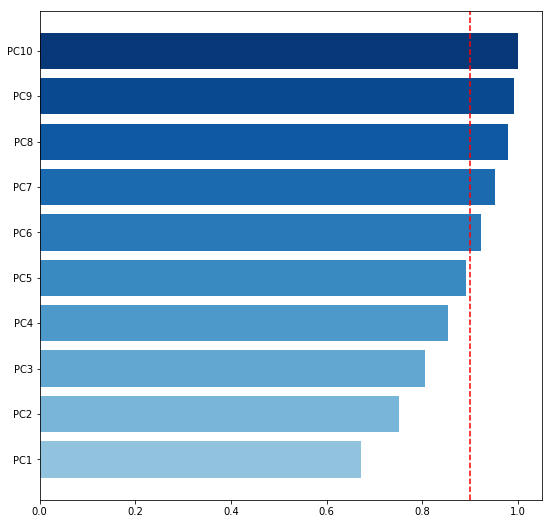

In [10]:
# input file
path = "breast-cancer-wisconsin.xlsx"

# Read file to pandasDF
data_df = pd.read_excel(os.path.abspath(path),index_col="code")

# For the momment let's just interpolate missing data by class
# Interpolating missing values to each column
data_2_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
data_4_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
data_imputed = pd.concat([data_4_imputed,data_2_imputed])

# Standardize data
data_s = StandardScaler().fit_transform(data_imputed) #PLEASE note we are standardizing the data
data_s = pd.DataFrame(data_s,index=data_imputed.index,columns=data_imputed.columns)

# PCA
scores, loadings, summary = runPCA(data_s)

# Plotting barplot to see the ammount of variance explain by the components
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
colors = get_colors_cmappalette(summary.index)
ax = plot_hbar(ax, xticks=summary.index.values, colors=colors,
               values = summary["cumulative_proportion_of_variance_explained"])

# Create a line at the 90% mark to see how many components are needed
plt.axvline(x=0.9, color='r', linestyle='--')

**Each sample is now characterized by a point in PCA space. Create a scatter plot matrix (in the  
same manner as in the previous sheet) that shows the first five principal components. This time,  
instead of histograms, each diagonal cell should contain two overlaid density plots, one for the  
benign and one for the malignant class. In the density plot, variable values should be on the x  
axis, the frequency of observing that value in each class should be on the y axis. Use different   
colors to distinguish between the classes, and add a legend. (5P)**

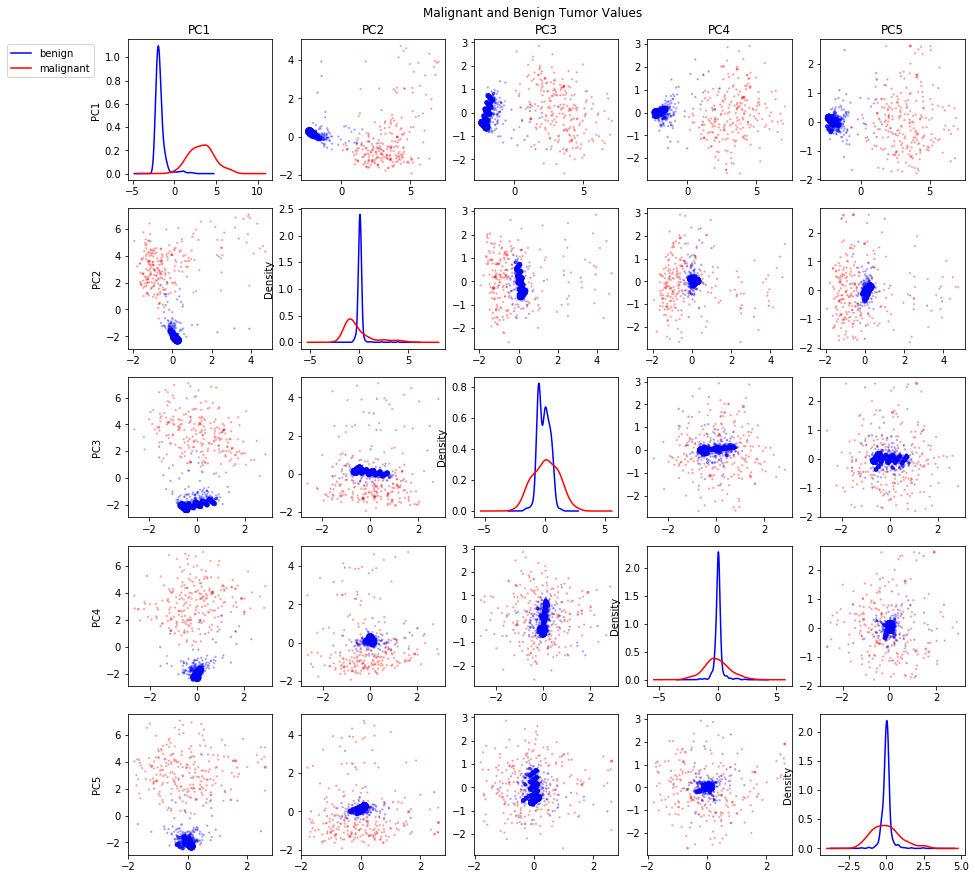

In [11]:
# Plot matrix scatterplot for the first 5 components
scores["class"] = data_imputed["class"]
plot_matrix_scatterplot(scores, summary.nlargest(5,"proportion_of_variance_explained").index, diag_kind="density")

**In which PCA modes do you see a clear difference between the benign samples and the malignant  
samples, in which modes the difference is less? (3P)**

PC1 and PC2 contain most of the variance and its in this two components where is easier
to distinguish the beningn and malignant samples appart.

PC2,PC3 and PC4 are not really that much helpfull to distinguish bettwen samples.

**Sometimes outliers (points that are quite far away from the rest of the data) could affect the data  
analysis. Provide the sample-Code or row index of the furthest point of malignant samples in the  
fourth PCA mode. Then remove that sample using its row index. (5P)**

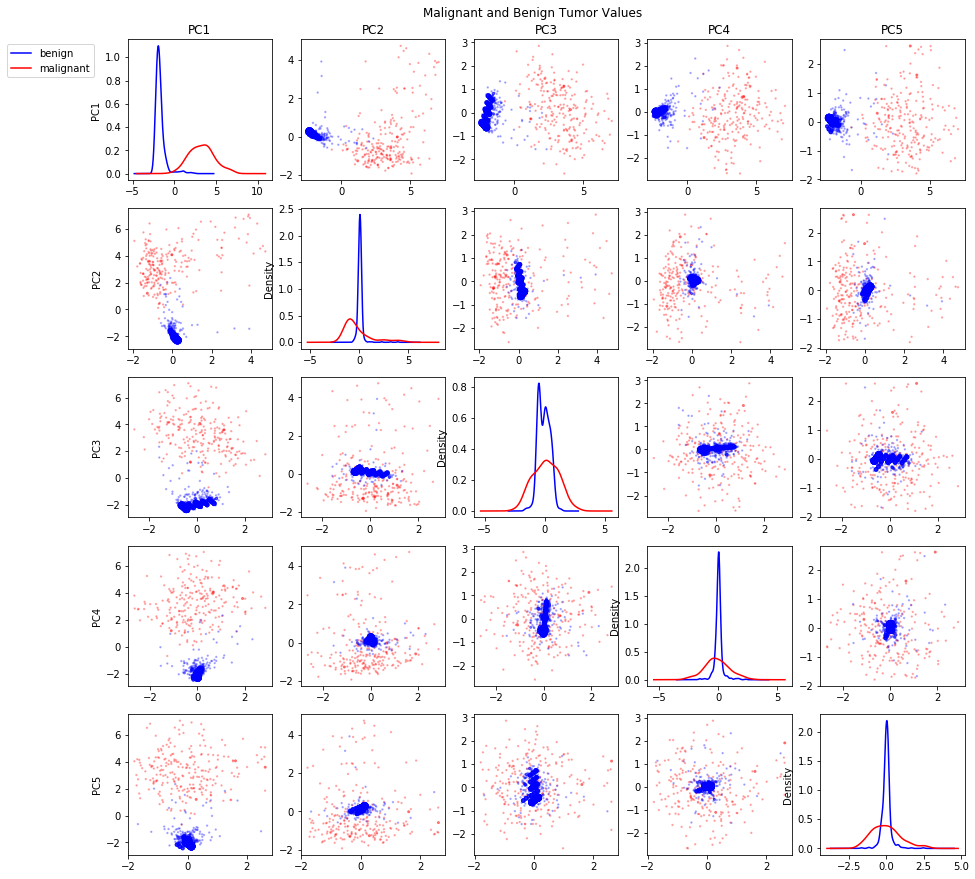

In [12]:
# With this line we can identify the farthest point 
farthest = scores[scores["class"]==4]["PC4"].abs().nlargest(1).index

# Now lets drop the sample using its index
scores_d = scores.drop(farthest)

# plot matrix scaterplot for data without the value
plot_matrix_scatterplot(scores_d, summary.nlargest(5,"proportion_of_variance_explained").index,diag_kind="density")

See what happens when we re-weight the variables to emphasize those that discriminate well  
between the benign and malignant classes. To do so, compute F scores (cf. sheet 2, task 1 d))  
and multiply each data value by its corresponding F score. Create two scatter plots to compare  
PCA results with and without the re-weighting. (5P)

Text(0.5,1,'Normal')

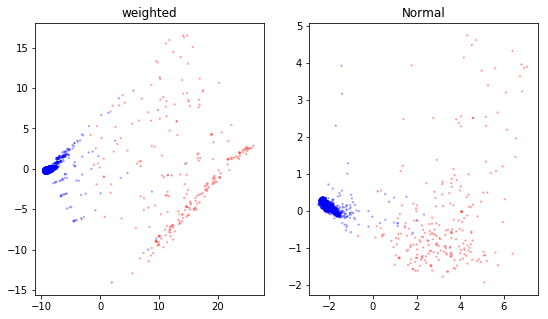

In [13]:
# Calculate F-Score for the imputed data
fscores = data_imputed.apply(get_f_score, axis=0, exclude=["class"],
                             groups=[benign_imputed, malig_imputed])
    
# Re weight data (_w)
data_w = data_imputed.apply(reweight, axis=0, weights=fscores, exclude=["class"])

# Standardize data (_w)
data_ws = StandardScaler().fit_transform(data_w)
data_ws = pd.DataFrame(data_w,index=data_imputed.index,columns=data_imputed.columns)

# Running PCA on weighted data (_w)
scores_w, loadings_w, summary_w = runPCA(data_ws)


# plot scatterplot to compare reweigthed values and standard values for first 2PC
fig, ax = plt.subplots(1, 2,figsize=(9, 5))

# Generate sizes by counting number of times a point occurs
datapoints = list(zip(scores_w["PC1"], scores_w["PC2"]))
sizes = [datapoints.count(point)*2 for point in datapoints]

# Create colors list
colors = ["blue" if row is 2 else "red" for row in list(scores['class'])]

# Create scatter plot at position i,j using created sizes/colors, alpha used for overlapping points
ax[0].scatter(scores_w["PC1"], scores_w["PC2"], alpha=0.25, c=colors, s=sizes)
ax[0].set_title("weighted")
ax[1].scatter(scores["PC1"], scores["PC2"], alpha=0.25, c=colors, s=sizes)
ax[1].set_title("Normal")

# plt.show()
# plt.savefig()

**In the breast cancer data-set, all the variables have a similar range of values v ∈ [1,10]. If the  
variables of a data-set have varying ranges, for example one variable have values around 1000 to  
2000 and another around 1 to 5, how could this affect the PCA performance. Explain how would  
you solve this problem? (2P)**

*Standardize features by removing the mean and scaling to unit variance (already implemented)*